In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_eul_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
MM,FO,TE,TE_conoid,q,u,fr,frstar,kindeq,xdot,activations = eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
time_to_create = tm.time() - start
print(time_to_create)

TE created
equations created
matlab functions generated
532.9576349258423


In [3]:
import equations as eq
reload (eq);
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondEul'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_eul(file,num_nodes)

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [17]:
traj_w = 250
vel_w = 0.1
act_w = 1

def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:10*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = traj_w * 2.0 * interval_value * (free[:10*num_nodes] - traj)
    grad[10*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [18]:
instance_constraints = []
for i in range(9):
    instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])

# instance_constraints.append(state_symbols[9].func(0.0)-x0t[9])

bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [19]:
start = tm.time()

prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #               
time_to_create = tm.time() - start
print(time_to_create)

1324.9636964797974


In [20]:
prob.add_option('max_iter',1000)
# prob.add_option('limited_memory_max_history', 40)

In [21]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj

In [22]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
1.9385832556214926


46.276913140997436


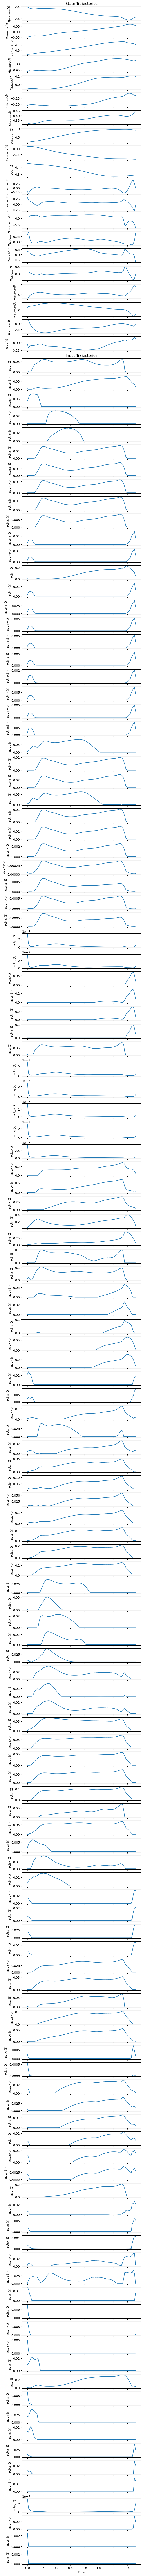

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print(act_obj)

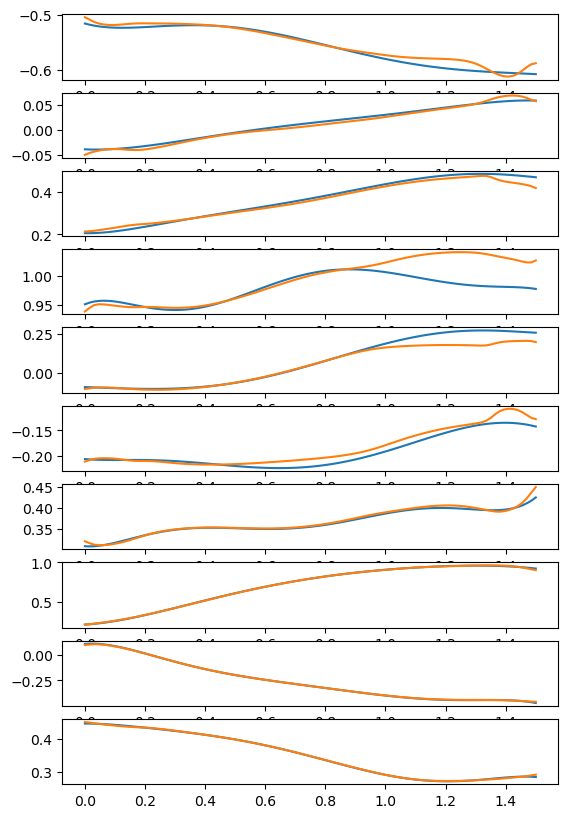

In [24]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

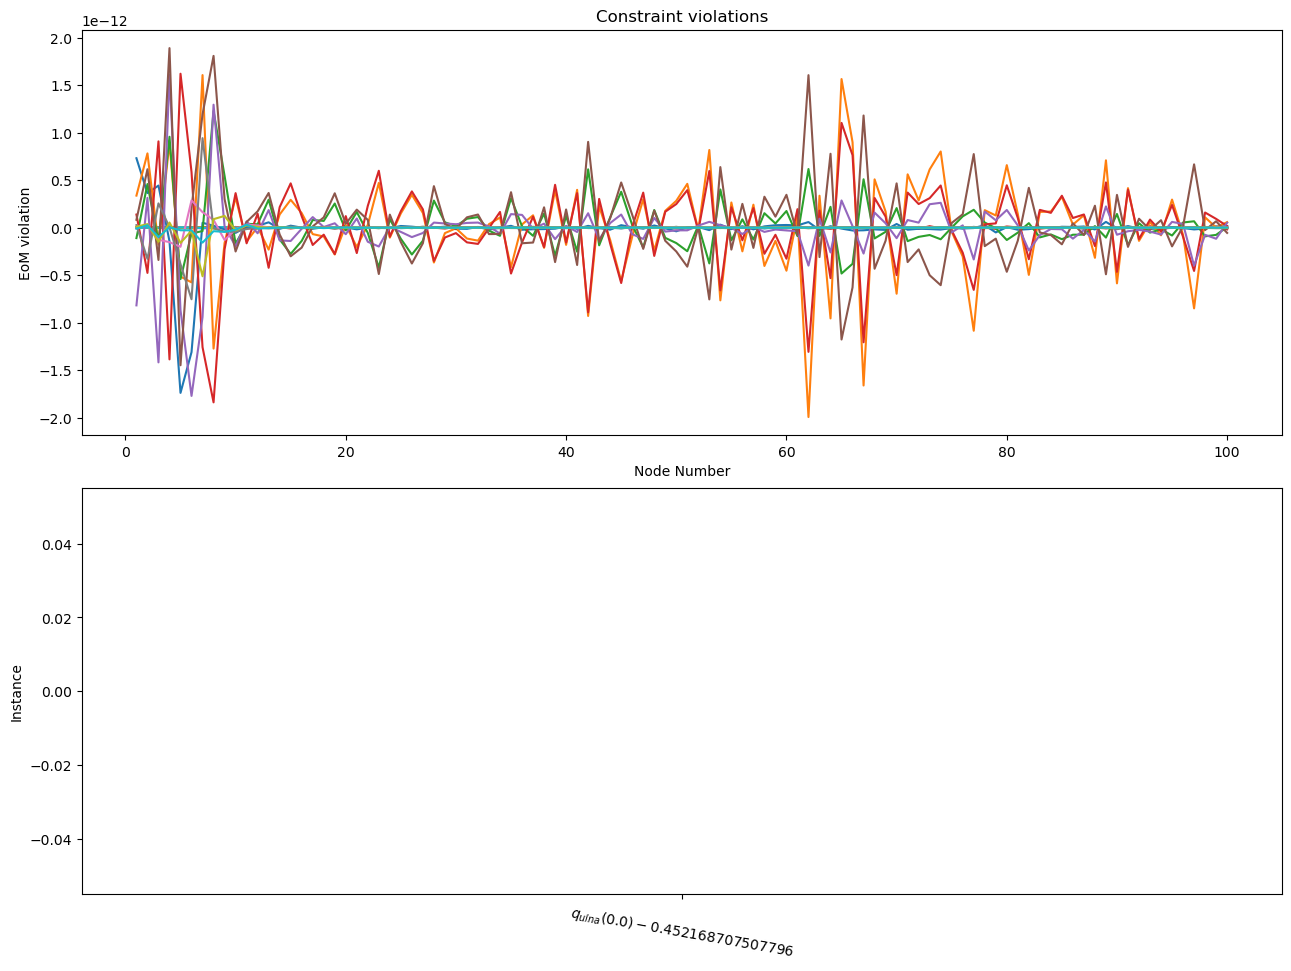

In [14]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)

In [15]:
# import equations as eq
# reload (eq);

# sol = eq.sol2mot_quat(solution, num_nodes, len(q), time)


In [25]:
import trajectory_lib as tr
reload (tr);
file_name = '../eul_abd_ICfixed.mat'
tr.quat2matfile(solution,activations,len(q),num_states,num_nodes,time,file_name)

Saved to .mat file
